## 5: Composing holoviews plots

So far we have generated plots using hvplot, but we haven't discussed what exactly these plots are and all the things that you can do with them. The short answer is that they are [holoviews](https://holoviews.org) objects rendered using the [bokeh](https://bokeh.org) backend. In the [last notebook](04_Using_.plot.ipynb) we saw holoviews supporting grouping and linking between subplots and bokeh supporting interactivity. 

In this notebook, we'll deconstruct hvplot output to show what individual elements are and discuss how they can be combined and used to compose layered visualizations.

### Read in the data

In [1]:
import dask.dataframe as dd

In [2]:
df = dd.read_parquet('../data/earthquakes.parq')
df.head()

depth  depthError     dmin     gap  horizontalError          id  \
index                                                                     
0       7.800       1.400  0.09500  245.14              NaN  nn00001936   
1       4.516       0.479  0.05131   52.50              NaN   ci9137218   
2      33.000         NaN      NaN     NaN              NaN  usp0009mwt   
3      33.000         NaN      NaN     NaN              NaN  usp0009mws   
4       7.200       0.900  0.11100  202.61              NaN  nn00001935   

       latitude locationSource  longitude   mag  ...  magSource  magType net  \
index                                            ...                           
0       37.1623             nn  -116.6037  0.60  ...         nn       ml  nn   
1       34.3610             ci  -116.1440  1.72  ...         ci       mc  ci   
2       10.6930            trn   -61.1620  2.10  ...        trn       md  us   
3       -1.2030             us   -80.7160  4.50  ...         us       mb  us   
4       38.7860             nn  -119.6409  1.40  ...         nn       ml  nn   

       nst                                     place     rms    status  \
index                                                                    
0      5.0                                    Nevada  0.0519  reviewed   
1      0.0  26km NNW of Twentynine Palms, California  0.1300  reviewed   
2      NaN             Trinidad, Trinidad and Tobago     NaN  reviewed   
3      NaN                 near the coast of Ecuador  0.6000  reviewed   
4      5.0                                    Nevada  0.0715  reviewed   

                                  time        type                   updated  
index                                                                         
0     2000-01-31 23:52:00.619000+00:00  earthquake  2018-04-24T22:22:44.135Z  
1     2000-01-31 23:44:54.060000+00:00  earthquake  2016-02-17T11:53:52.643Z  
2     2000-01-31 23:28:38.420000+00:00  earthquake  2014-11-07T01:09:23.016Z  
3     2000-01-31 23:05:22.010000+00:00  earthquake  2014-11-07T01:09:23.014Z  
4     2000-01-31 22:56:50.996000+00:00  earthquake  2018-04-24T22:22:44.054Z  

[5 rows x 22 columns]

Next we'll clean the data as we did in the last notebook. We'll also reindex by time so that we can do more easily do resampling. 

In [3]:
cleaned_df = df.copy()
cleaned_df['mag'] = df.mag.where(df.mag > 0)
cleaned_reindexed_df = cleaned_df.set_index(cleaned_df.time)

If you have enough RAM, everything else in this notebook will be faster if you persist the data in memory.

In [4]:
cleaned_reindexed_df = cleaned_reindexed_df.persist()

### Composing plots
In this section we'll start looking at how we can group plots to derive greater meaning. We'll start by resampling the data to explore patterns in number and magnitude of earthquakes over time. 

In [5]:
import hvplot.dask

In [6]:
monthly_count = cleaned_reindexed_df.id.resample('1M').count().rename('count')
monthly_count_plot = monthly_count.hvplot(title='Monthly count')
monthly_count_plot

:Curve   [time]   (count)

Let's take a closer look at this plot object.

In [7]:
print(monthly_count_plot)

:Curve   [time]   (count)


This is holoviews notation for saying that the plot is a `Curve` element with `time` as the key dimension (`kdim`) and `count` as the value dimension (`vdim`).

In [8]:
### Exercise: Use tab completion to explore monthly_count_plot. Try .data or .table()

In [9]:
monthly_mean_magnitude = cleaned_reindexed_df.mag.resample('1M').mean()
monthly_mean_magnitude_plot = monthly_mean_magnitude.hvplot(title='Monthly mean magnitude')
monthly_mean_magnitude_plot

:Curve   [time]   (mag)

In [10]:
print(monthly_mean_magnitude_plot)

:Curve   [time]   (mag)


This plot has time on the x axis like the other, but the value dimension is magnitude rather than count. Holoviews supports composing plots from individual elements using the `+` symbol to see them side-by-side with linked axes for any shared dimensions. 

In [11]:
(monthly_mean_magnitude_plot + monthly_count_plot).cols(1)

:Layout
   .Curve.Mag   :Curve   [time]   (mag)
   .Curve.Count :Curve   [time]   (count)

In [12]:
### Exercise: Zoom in and out to explore the linking between the plots.

### Adding a third dimension

Now let's filter the earthquakes to only include the really high intensity ones. We can add extra dimensions to the visualization by using color in addition to x and y.

In [13]:
import hvplot.pandas

In [14]:
most_severe = df[df.mag >= 7].compute()

In [15]:
most_severe.plot.scatter(x='longitude', y='latitude', c='mag')

In [16]:
high_mag_scatter = most_severe.hvplot.scatter(x='longitude', y='latitude', c='mag')
high_mag_scatter

:Scatter   [longitude]   (latitude,mag)

In [17]:
print(high_mag_scatter)

:Scatter   [longitude]   (latitude,mag)


Tweaking the options to create a better plot. First we'll use [colorcet](https://colorcet.pyviz.org) to get a colormap that doesn't have white at one end. We can choose one from the website and use the plotting module to make sure it looks good. 

In [18]:
import colorcet as cc
from colorcet.plotting import swatch, swatches  #noqa: might use swatches in the exercise

In [19]:
swatch('CET_L4')

:Image   [x,y]   (z)

We'll reverse the colors to align dark reds with higher magnitude earthquakes.

In [20]:
mag_cmap = cc.CET_L4[::-1]

In addition to fixing the colormap, we can switch from using `scatter` to using `points`, add some addition columns to the hover text, and add a title.

In [21]:
high_mag_points = most_severe.hvplot.points(x='longitude', y='latitude', c='mag',
                                            hover_cols=['place', 'time'],
                                            cmap=mag_cmap, 
                                            title='Earthquakes with magnitude >= 7')
high_mag_points

:Points   [longitude,latitude]   (mag,place,time)

When you hover over the points you'll see the place and time of the earthquake in addition to the magnitude and lat/lon. This is reflected in the dimensions that holoviews is keeping track of.

In [22]:
print(high_mag_points)

:Points   [longitude,latitude]   (mag,place,time)


In [23]:
### Exercise: Use the colorcet plotting module swatches(group='linear') to choose a different colormap. 

### Overlay with a tiled map 

That colormap is better, and we can kind of see the outlines of the continents, but the visualization would be much easier to parse if we added a base map underneath. To do this, we'll import a tile element from holoviews. 

In [24]:
from holoviews.element.tiles import OSM

OSM()

:Tiles   [x,y]

When you zoom the map becomes more and more detailed. In order to overlay this basemap, we need to project our earthquakes to Web Mercator.

In [25]:
import pandas as pd
import datashader.geo

In [26]:
x, y = datashader.geo.lnglat_to_meters(most_severe.longitude, most_severe.latitude)
most_severe_projected = most_severe.join([pd.DataFrame({'x': x}), pd.DataFrame({'y': y})])

In [27]:
OSM() * most_severe_projected.hvplot.scatter(x='x', y='y', c='mag', 
                                             hover_cols=['place', 'time'], 
                                             cmap=mag_cmap, 
                                             title='Earthquakes with magnitude >= 7')

:Overlay
   .Tiles.I   :Tiles   [x,y]
   .Scatter.I :Scatter   [x]   (y,mag,place,time)

In [28]:
### Exercise: Import and use different tiles. Try EsriImagery or Wikipedia.

### Overlay with a raster
That base map is helpful for orienting ourselves, but it isn't really adding too much new information. We might instead like to overlay the earthquakes on a map of global population. We'll start by reading in a geotiff containing a raster of global population. We'll use [xarray](https://xarray.pydata.org) with a [rasterio](https://rasterio.readthedocs.io) backend to load these data.

In [29]:
import xarray as xr
import hvplot.xarray

In [30]:
ds = xr.open_rasterio('../data/gpw_v4_population_density_rev11_2010_2pt5_min.tif')
ds

<xarray.DataArray (band: 1, y: 4320, x: 8640)>
[37324800 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * x        (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9 180.0
Attributes:
    transform:   (0.0416666666666667, 0.0, -180.0, 0.0, -0.0416666666666667, ...
    crs:         EPSG:4326
    res:         (0.0416666666666667, 0.0416666666666667)
    is_tiled:    0
    nodatavals:  (-3.4028230607370965e+38,)

In [31]:
cleaned_ds = ds.where(ds.values != ds.nodatavals[0]).sel(band=1)
cleaned_ds.name = 'population'

The `xarray.plot()` API is fine for plotting small sections of this dataset, but it doesn't do well with the full resolution. For that it is better to use `hvplot` to take advantage of datashading. Here we are plotting Indonesia.

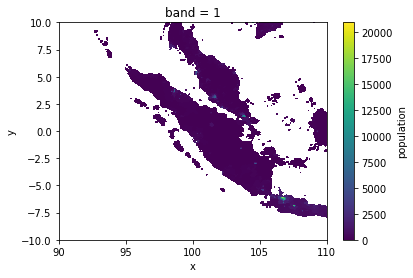

In [32]:
ROI = cleaned_ds.sel(y=slice(10, -10), x=slice(90, 110))
ROI.plot()

In [33]:
rasterized_pop = cleaned_ds.hvplot.image(rasterize=True)
rasterized_pop

:DynamicMap   []
   :Image   [x,y]   (population)

By inspecting the holoviews object, we can see that the output isn't actually an image, instead it is a dynamic map. This means that the image that is displayed is actually just one of many images that are computed on the fly (dynamically).

In [34]:
print(rasterized_pop)

:DynamicMap   []
   :Image   [x,y]   (population)


In [35]:
### Exercise: Use .last to inspect the last image from the DynamicMap. Zoom into the plot above and inspect .last again.

Now we can clean up the styling on this map because the color scale and the color map make it very hard to see what's going on. We'll also overlay this with the earthquakes.

In [36]:
title = 'High magnitude (>=7) earthquakes over population density [people/km^2] from 2000 to 2019'
rasterized_pop = cleaned_ds.hvplot.image(
    rasterize=True, cmap='kbc_r', height=600, width=1000, xaxis=None, yaxis=None).opts(logz=True)
high_mag_points = most_severe.hvplot.points(
    x='longitude', y='latitude', c='mag', hover_cols=['place', 'time'], cmap=mag_cmap)

pop_and_high_mag = (rasterized_pop * high_mag_points).relabel(title)
pop_and_high_mag 

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [x,y]   (population)
      .Points.I :Points   [longitude,latitude]   (mag,place,time)

In [37]:
print(pop_and_high_mag)

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [x,y]   (population)
      .Points.I :Points   [longitude,latitude]   (mag,place,time)


In the [next notebook](06_Custom_Interactivity.ipynb) we'll learn more about how to use holoviews effectively to keep building up plots with custom interactivity.